In [81]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE

In [82]:
df = pd.read_csv('./train.csv')

In [83]:
label_ = list(set(df['label_action']))
label_cnt = len(label_)

idx = []
for i in range (0, label_cnt):
    idx.append(i)
ldf = df.replace(label_, idx)

# 0. Preprocessing

## 0.1. Decode URL
URL은 %NN 형태로 인코딩되어있기 때문에 디코딩을 해줄 것이다.

In [84]:
from urllib.parse import unquote
#test
test_url = ldf.payload[4]
dec_url = unquote(test_url)
print("Before:", test_url)
print("After:", dec_url)



Before: GET /sub_04_1_read.php?page=1&id=31%29%3BSELECT%20%2A%20FROM%20GENERATE_SERIES%289156%2C9156%2CCASE%20WHEN%20%289156%3D5350%29%20THEN%201%20ELSE%200%20END%29%20LIMIT%201-- HTTP/1.1\r\nCache-Control: no-cache\r\nUser-Agent: sqlmap/1.6.10#stable (https://sqlmap.org)\r\nReferer: http://10.0.17.20:80/sub_04_1_read.php\r\nHost: 10.0.17.20\r\nAccept: */*\r\nAccept-Encoding: gzip,deflate\r\nConnection: close\r\n\r\n
After: GET /sub_04_1_read.php?page=1&id=31);SELECT * FROM GENERATE_SERIES(9156,9156,CASE WHEN (9156=5350) THEN 1 ELSE 0 END) LIMIT 1-- HTTP/1.1\r\nCache-Control: no-cache\r\nUser-Agent: sqlmap/1.6.10#stable (https://sqlmap.org)\r\nReferer: http://10.0.17.20:80/sub_04_1_read.php\r\nHost: 10.0.17.20\r\nAccept: */*\r\nAccept-Encoding: gzip,deflate\r\nConnection: close\r\n\r\n


이런 형태로 모든 스트링에 적용시켜준다

In [85]:
from urllib.parse import unquote
decoded_payload = []
for url in ldf.payload:
    decoded_payload.append(unquote(url))
pd.options.display.max_colwidth = 100
ldf.payload = decoded_payload


In [86]:
ldf.to_csv("./decoded.csv", escapechar='\\')

잘 디코딩이 된 것을 확인할 수 있다.

## 0.2. 불필요한 데이터 제거
payload의 모든 내용이 학습에 도움이 되는 것은 아니다. 
문자열을 feature data로 사용할 때 중요한 것은 실제로 공격에 사용된 부분이다. 
따라서 크게 영향을 주지 않을 것으로 부분들을 제거할것이다

In [87]:
duplicate_values = ldf['payload'].duplicated()
i = 0
cnt = 0
for pl in df.payload:
    if (duplicate_values[i] == True):
        cnt += 1
    i += 1
print("Number of dupes: ", cnt)

Number of dupes:  13246


In [88]:
ldf = ldf.drop_duplicates(subset=['payload'])

In [89]:
ldf

,Log_Number,payload,label_action
0,0,"GET /forum1_professionnel.asp?n=/.\\\""./.\\\""./.\\\""./.\\\""./.\\\""./boot.ini&amp;nn=100&amp;page...",5
1,1,"POST /owa/auth/logon.aspx?replaceCurrent=1"") AND 9294=UTL_INADDR.GET_HOST_ADDRESS(CHR(113)||CHR(...",5
2,2,GET /goods/goods_search?display_type=list&arr_search_list[0][search_type]=-1839 or 1=2&arr_searc...,4
3,3,GET / HTTP/1.1\r\n\r\n,8
4,4,"GET /sub_04_1_read.php?page=1&id=31);SELECT * FROM GENERATE_SERIES(9156,9156,CASE WHEN (9156=535...",5
...,...,...,...
44993,44993,GET /admin/captcha/securimage_show?160c3e6d29ea99621a9ddced77261577=../../../../../../../../../....,3
44995,44995,GET /app/javascript/js/skin-responsive.js?v=; HTTP/1.1\r\nHost: www.mall.shop\r\nUser-Agent: Moz...,5
44996,44996,GET /board/?category=type+%SYSTEMROOT%\win.ini&goods_seq=&id=goods_qna&iframe=&page=&perpage=&po...,5
44997,44997,POST /sub_02_4.php HTTP/1.1\r\nContent-Length: 118\r\nCache-Control: no-cache\r\nCookie: df8k365...,4


## Tokenizing
공백, &, =, :, ;, +로 문자열 분리하기

In [90]:

split_payload = []
for payload in ldf.payload:
    payload = payload.replace("\\r\\n",',')
    table = payload.maketrans("&=;: ", ",,,,,")
    payload = payload.translate(table)
    tokens = payload.split(',')
    #tokens = payload.split('\\r\\n')
    while("" in tokens):
        tokens.remove('')
    split_payload.append(tokens)
ldf.payload = split_payload

In [91]:
ldf.to_csv("./split.csv")

In [92]:
ldf

,Log_Number,payload,label_action
0,0,"[GET, /forum1_professionnel.asp?n, /.\\\""./.\\\""./.\\\""./.\\\""./.\\\""./boot.ini, amp, nn, 100, a...",5
1,1,"[POST, /owa/auth/logon.aspx?replaceCurrent, 1""), AND, 9294, UTL_INADDR.GET_HOST_ADDRESS(CHR(113)...",5
2,2,"[GET, /goods/goods_search?display_type, list, arr_search_list[0][search_type], -1839, or, 1, 2, ...",4
3,3,"[GET, /, HTTP/1.1]",8
4,4,"[GET, /sub_04_1_read.php?page, 1, id, 31), SELECT, *, FROM, GENERATE_SERIES(9156, 9156, CASE, WH...",5
...,...,...,...
44993,44993,"[GET, /admin/captcha/securimage_show?160c3e6d29ea99621a9ddced77261577, ../../../../../../../../....",3
44995,44995,"[GET, /app/javascript/js/skin-responsive.js?v, HTTP/1.1, Host, www.mall.shop, User-Agent, Mozill...",5
44996,44996,"[GET, /board/?category, type+%SYSTEMROOT%\win.ini, goods_seq, id, goods_qna, iframe, page, perpa...",5
44997,44997,"[POST, /sub_02_4.php, HTTP/1.1, Content-Length, 118, Cache-Control, no-cache, Cookie, df8k36559u...",4


#Hash

In [93]:
# from hashlib import sha256

# # for payload in ldf.payload:
# #     if (len(payload) == 185):
# #         print(payload)
# new_payload = []
# for payload in ldf.payload:
#     hashed_payload = []
#     for field in payload:
#         hash = sha256(field.encode())
#         hash2 = hash.hexdigest()
#         hashed_payload.append(hash2)
#     new_payload.append(hashed_payload)
# ldf.payload = new_payload



In [94]:
ldf

,Log_Number,payload,label_action
0,0,"[GET, /forum1_professionnel.asp?n, /.\\\""./.\\\""./.\\\""./.\\\""./.\\\""./boot.ini, amp, nn, 100, a...",5
1,1,"[POST, /owa/auth/logon.aspx?replaceCurrent, 1""), AND, 9294, UTL_INADDR.GET_HOST_ADDRESS(CHR(113)...",5
2,2,"[GET, /goods/goods_search?display_type, list, arr_search_list[0][search_type], -1839, or, 1, 2, ...",4
3,3,"[GET, /, HTTP/1.1]",8
4,4,"[GET, /sub_04_1_read.php?page, 1, id, 31), SELECT, *, FROM, GENERATE_SERIES(9156, 9156, CASE, WH...",5
...,...,...,...
44993,44993,"[GET, /admin/captcha/securimage_show?160c3e6d29ea99621a9ddced77261577, ../../../../../../../../....",3
44995,44995,"[GET, /app/javascript/js/skin-responsive.js?v, HTTP/1.1, Host, www.mall.shop, User-Agent, Mozill...",5
44996,44996,"[GET, /board/?category, type+%SYSTEMROOT%\win.ini, goods_seq, id, goods_qna, iframe, page, perpa...",5
44997,44997,"[POST, /sub_02_4.php, HTTP/1.1, Content-Length, 118, Cache-Control, no-cache, Cookie, df8k36559u...",4


In [95]:
max_len = 0
field_len = []
for payload in ldf.payload:
    max_len = max(max_len, len(payload))
i = 0
print("Max len: ", max_len)
for payload in ldf.payload:
    field_len.append(len(payload))

print(field_len)



Max len:  887
[28, 49, 59, 3, 41, 28, 112, 31, 27, 25, 14, 52, 21, 49, 100, 31, 77, 119, 81, 55, 81, 37, 58, 111, 50, 21, 16, 25, 97, 38, 39, 67, 56, 25, 20, 150, 20, 25, 45, 21, 23, 8, 15, 21, 77, 27, 35, 110, 21, 75, 41, 69, 131, 21, 63, 49, 8, 22, 33, 55, 54, 37, 27, 97, 76, 79, 62, 24, 96, 38, 73, 115, 21, 51, 16, 80, 16, 55, 139, 30, 97, 28, 19, 21, 69, 81, 22, 9, 21, 52, 25, 105, 52, 97, 27, 123, 25, 63, 21, 15, 92, 49, 39, 40, 41, 25, 69, 24, 92, 101, 112, 24, 77, 15, 127, 52, 20, 19, 15, 23, 55, 15, 21, 44, 21, 19, 60, 23, 26, 40, 50, 64, 25, 78, 85, 22, 9, 3, 40, 15, 28, 20, 53, 34, 19, 52, 80, 64, 21, 52, 27, 118, 14, 27, 34, 48, 37, 77, 52, 113, 19, 92, 110, 92, 115, 27, 74, 49, 28, 15, 118, 43, 42, 104, 40, 85, 48, 68, 20, 19, 29, 93, 19, 29, 20, 28, 21, 77, 96, 37, 22, 19, 57, 35, 15, 77, 41, 23, 39, 19, 19, 20, 39, 22, 8, 110, 15, 87, 40, 28, 52, 21, 61, 30, 19, 19, 14, 111, 15, 91, 75, 19, 15, 22, 21, 41, 29, 85, 19, 37, 37, 66, 47, 97, 35, 19, 15, 112, 77, 129, 19, 15, 

(array([3.1748e+04, 3.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  3. , 179.8, 356.6, 533.4, 710.2, 887. ]),
 <BarContainer object of 5 artists>)

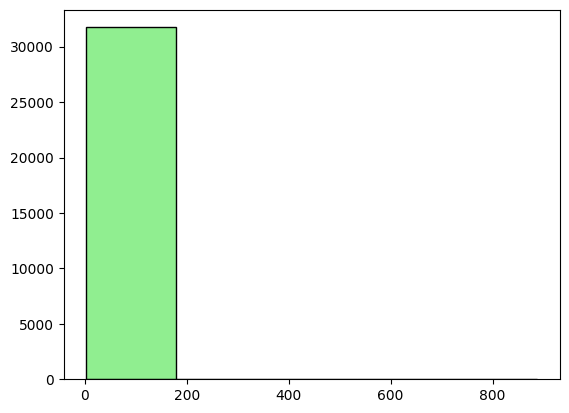

In [96]:
import matplotlib.pyplot as plt

#create histogram
plt.hist(field_len, color='lightgreen', ec='black', bins=5)

In [97]:
ldf['token_num'] = field_len 

In [98]:
ldf = ldf[ldf.token_num < 120]

In [99]:
ldf

,Log_Number,payload,label_action,token_num
0,0,"[GET, /forum1_professionnel.asp?n, /.\\\""./.\\\""./.\\\""./.\\\""./.\\\""./boot.ini, amp, nn, 100, a...",5,28
1,1,"[POST, /owa/auth/logon.aspx?replaceCurrent, 1""), AND, 9294, UTL_INADDR.GET_HOST_ADDRESS(CHR(113)...",5,49
2,2,"[GET, /goods/goods_search?display_type, list, arr_search_list[0][search_type], -1839, or, 1, 2, ...",4,59
3,3,"[GET, /, HTTP/1.1]",8,3
4,4,"[GET, /sub_04_1_read.php?page, 1, id, 31), SELECT, *, FROM, GENERATE_SERIES(9156, 9156, CASE, WH...",5,41
...,...,...,...,...
44993,44993,"[GET, /admin/captcha/securimage_show?160c3e6d29ea99621a9ddced77261577, ../../../../../../../../....",3,109
44995,44995,"[GET, /app/javascript/js/skin-responsive.js?v, HTTP/1.1, Host, www.mall.shop, User-Agent, Mozill...",5,65
44996,44996,"[GET, /board/?category, type+%SYSTEMROOT%\win.ini, goods_seq, id, goods_qna, iframe, page, perpa...",5,100
44997,44997,"[POST, /sub_02_4.php, HTTP/1.1, Content-Length, 118, Cache-Control, no-cache, Cookie, df8k36559u...",4,38


(array([11345.,  6619.,  4528.,  4541.,  3223.]),
 array([  3. ,  26.2,  49.4,  72.6,  95.8, 119. ]),
 <BarContainer object of 5 artists>)

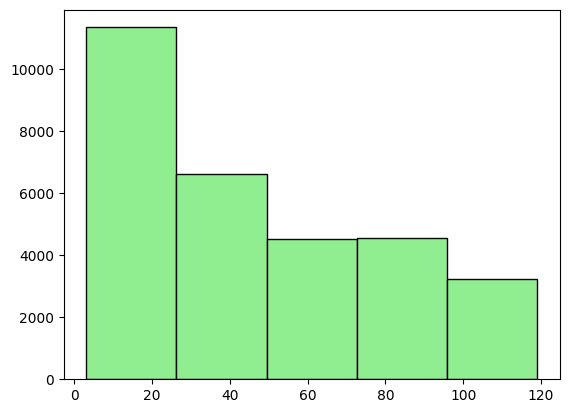

In [100]:
#create histogram
plt.hist(ldf.token_num, color='lightgreen', ec='black', bins=5)



In [101]:
max_len = 0
for token_num in ldf.token_num:
    max_len = max(max_len, token_num)
print(max_len)

119


In [102]:
for payload in ldf.payload:
    while (len(payload) < 119):
        payload.append("")


[119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119,

/tmp/ipykernel_46940/1081477027.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldf['token_num'] = field_len


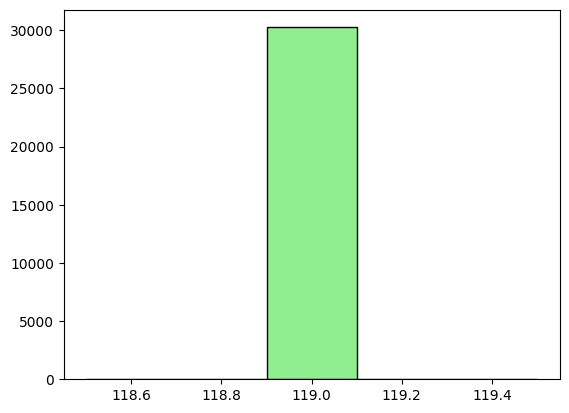

In [103]:
#create histogram
field_len = []
for payload in ldf.payload:
    field_len.append(len(payload))
ldf['token_num'] = field_len 
plt.hist(ldf.token_num, color='lightgreen', ec='black', bins=5)
print(field_len)



In [104]:
# from hashlib import sha256
# new_payload = []
# for payload in ldf.payload:
#     hashed_payload = []
#     for token in payload:
#         hash = sha256(token.encode())
#         hash2 = hash.hexdigest()
#         hashed_payload.append(hash2)
#     new_payload.append(hashed_payload)
# ldf.payload = new_payload

In [105]:
ldf

,Log_Number,payload,label_action,token_num
0,0,"[GET, /forum1_professionnel.asp?n, /.\\\""./.\\\""./.\\\""./.\\\""./.\\\""./boot.ini, amp, nn, 100, a...",5,119
1,1,"[POST, /owa/auth/logon.aspx?replaceCurrent, 1""), AND, 9294, UTL_INADDR.GET_HOST_ADDRESS(CHR(113)...",5,119
2,2,"[GET, /goods/goods_search?display_type, list, arr_search_list[0][search_type], -1839, or, 1, 2, ...",4,119
3,3,"[GET, /, HTTP/1.1, , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , ,...",8,119
4,4,"[GET, /sub_04_1_read.php?page, 1, id, 31), SELECT, *, FROM, GENERATE_SERIES(9156, 9156, CASE, WH...",5,119
...,...,...,...,...
44993,44993,"[GET, /admin/captcha/securimage_show?160c3e6d29ea99621a9ddced77261577, ../../../../../../../../....",3,119
44995,44995,"[GET, /app/javascript/js/skin-responsive.js?v, HTTP/1.1, Host, www.mall.shop, User-Agent, Mozill...",5,119
44996,44996,"[GET, /board/?category, type+%SYSTEMROOT%\win.ini, goods_seq, id, goods_qna, iframe, page, perpa...",5,119
44997,44997,"[POST, /sub_02_4.php, HTTP/1.1, Content-Length, 118, Cache-Control, no-cache, Cookie, df8k36559u...",4,119


In [111]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

#sg=0
#w2v_model = Word2Vec(sentences=payload, vector_size=119, window=5, min_count=5, workers=4, sg=0)
#sg=1
w2v_model = Word2Vec(sentences=ldf.payload, vector_size=100, window=5, min_count=5, workers=4, sg=1)

In [107]:
type(w2v_model)

gensim.models.word2vec.Word2Vec

In [108]:
print(w2v_model)

Word2Vec<vocab=3986, vector_size=100, alpha=0.025>


In [109]:
v = w2v_model.wv.get_vector('GET')
print(v)
len(v)

[-2.12979698e+00  3.53979319e-02  1.70123875e+00 -3.02825189e+00
  1.45701730e+00  1.13532439e-01  2.83231783e+00  1.33523262e+00
 -2.84371734e+00 -1.85539186e+00  2.05088902e+00 -2.86550999e+00
 -8.52690935e-01  4.75502014e+00  4.09131825e-01 -3.42079639e+00
 -2.79044771e+00 -8.32850873e-01 -1.66843235e+00 -3.16714454e+00
 -3.62365067e-01 -1.53523457e+00  3.82780337e+00 -9.42032754e-01
  1.31887841e+00  2.06379223e+00 -3.61603165e+00 -5.91432047e+00
 -7.06517518e-01 -1.61957014e+00 -2.10657325e-02 -7.89340615e-01
  2.36653876e+00  1.67894930e-01  2.43424326e-01  1.82108849e-01
 -2.47849536e+00  1.27998412e+00  1.93861055e+00 -2.53716016e+00
  2.53053784e+00 -3.64683688e-01  2.68774819e+00  2.06071901e+00
  2.90533638e+00  1.74208283e+00 -3.46438050e+00 -2.74902320e+00
 -1.35968947e+00 -3.37650776e-01  1.07553148e+00  2.52087021e+00
 -1.98542094e+00  2.41403794e-03  2.39418960e+00 -2.28606296e+00
  1.55734921e+00  1.51079923e-01  3.61252165e+00 -2.22523785e+00
 -3.17235470e-01 -2.11059

100

In [112]:
w2v_model.wv.most_similar('User-Agent')

[('388', 0.5718904733657837),
 ('/Autodiscover/', 0.5635490417480469),
 ('/login_process/login', 0.5554493069648743),
 ('Mozilla/5.0', 0.554679274559021),
 ('231', 0.5497869253158569),
 ('300', 0.5440104603767395),
 ('/phpmyadmin/', 0.5439437031745911),
 ('/phpMyAdmin-2.5.6-rc1/', 0.5409231185913086),
 ('211', 0.539526641368866),
 ('308', 0.5378744006156921)]